In [2]:
%load_ext autoreload
%autoreload 2

import h5py
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import LsNMF

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import torch
import time
import numpy as np

# Load & Format Data

In [4]:
arrays={}
g = h5py.File('Vc_Uc.mat')
for k, v in g.items():
    print(k)
    arrays[k] = np.array(v)

Uc
Vc
brainmask_aligned
newtrialidxs


In [6]:
new_x, new_y = 580, 540
dorsalMapScaled = sio.loadmat('dorsalMaps.mat')['dorsalMapScaled']
dorsalMapScaled[:,:int(dorsalMapScaled.shape[1]/2)] = dorsalMapScaled[:,:int(dorsalMapScaled.shape[1]/2)] * -1
dorsalMapScaled = dorsalMapScaled[:new_y, :new_x]

In [7]:
V=arrays['Vc'].T
num_frames = V.shape[-1]
num_frames -= num_frames % 32
V = V[:,:num_frames]

In [8]:
print(V.shape)

(941, 88640)


In [9]:
U=arrays['Uc'].transpose((2,1,0))[:new_y, :new_x, :]
brainmask=~np.isnan(arrays['brainmask_aligned'].T[:new_y, :new_x])
trialidxs=arrays['newtrialidxs'].T
del arrays

In [10]:
q, r = np.linalg.qr(V.T)

# adaptive_localized_factorize(...)

In [11]:
video_mats = (np.copy(U[brainmask]), r.T)#V)
del U
valid_mask = brainmask
region_map = dorsalMapScaled
rank_range = (2, 14, 1)
device='cuda'

In [19]:
region_mats = LsNMF.extract_region_metadata(valid_mask,
                                            region_map,
                                            min_size=rank_range[1])

In [20]:
A = np.zeros(valid_mask.shape, dtype=np.float32)
A[valid_mask] = region_mats[1][1]

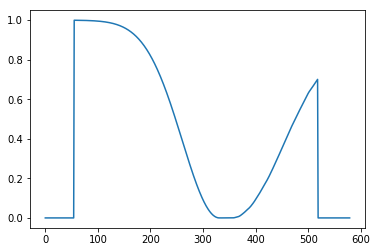

In [21]:
sigma=.0001
plt.plot(np.arange(len(A[200])), 1 - np.exp(-1*np.power(A[300],2) * sigma))
plt.show()

In [22]:
region_mats[1][:] = 1 - np.exp(-1*np.power(region_mats[1],2) * sigma)

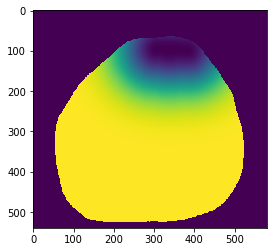

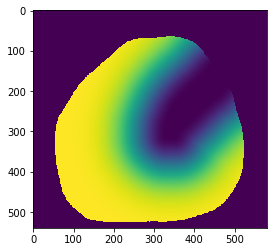

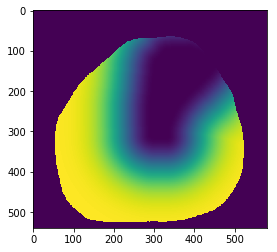

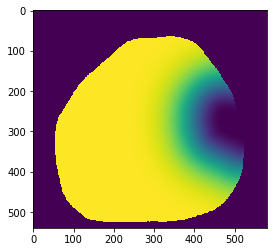

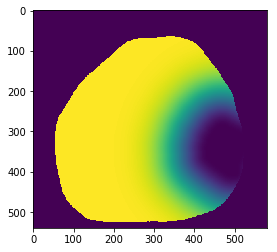

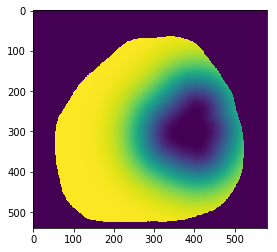

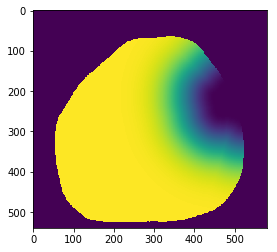

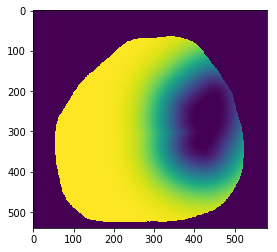

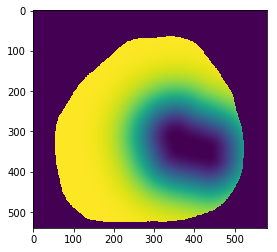

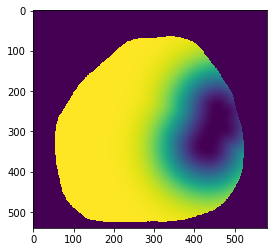

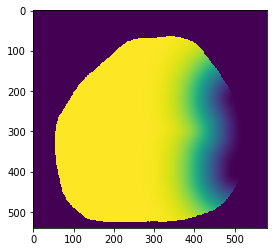

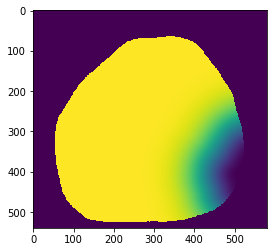

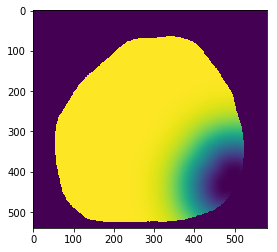

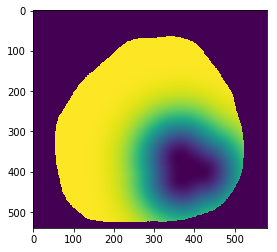

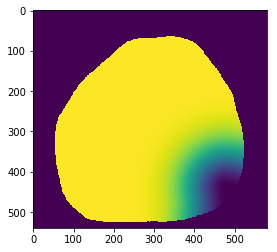

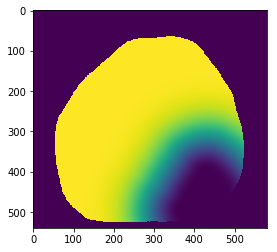

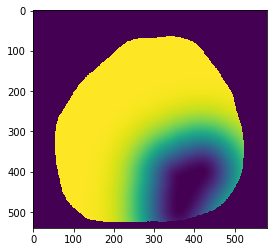

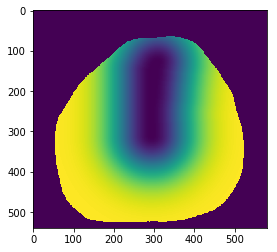

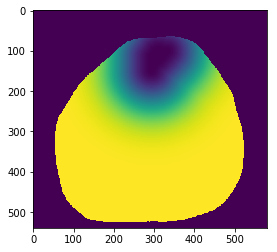

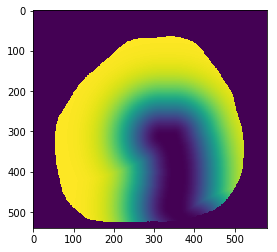

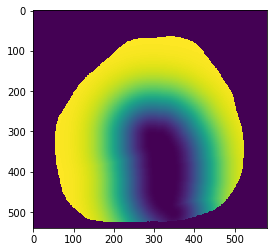

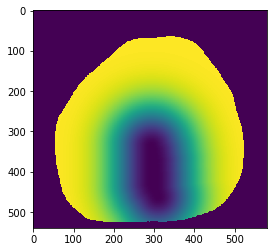

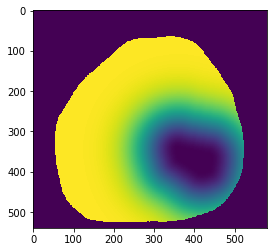

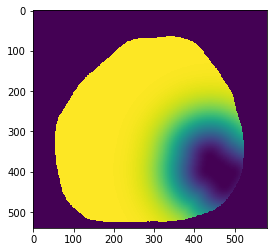

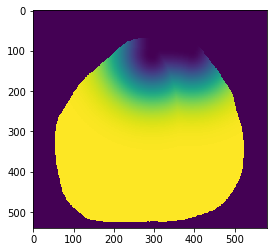

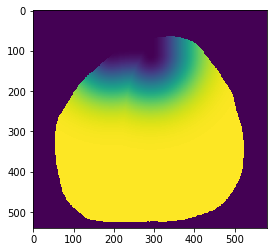

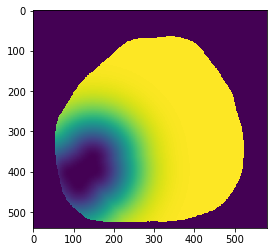

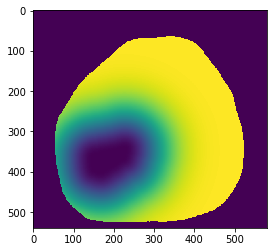

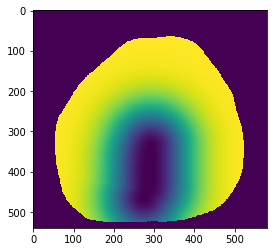

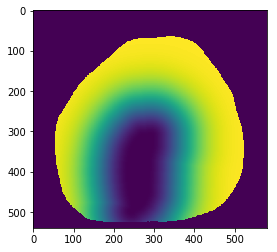

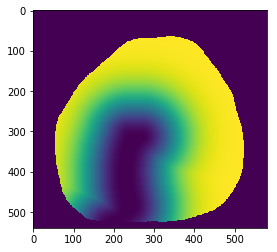

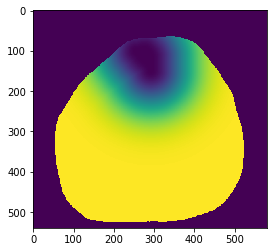

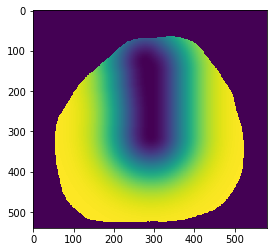

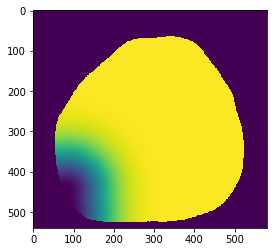

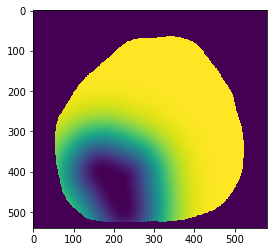

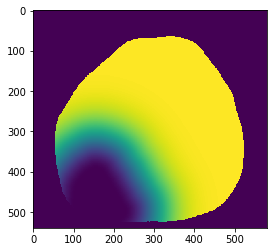

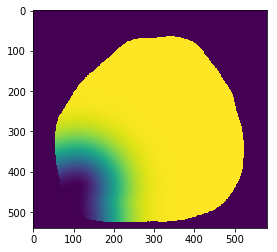

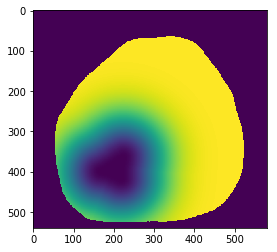

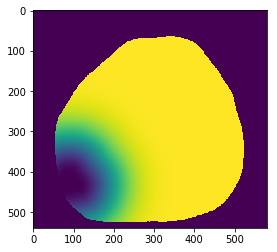

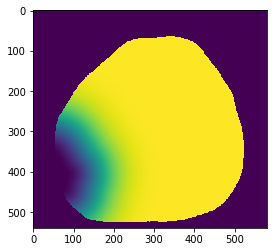

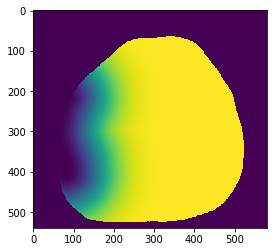

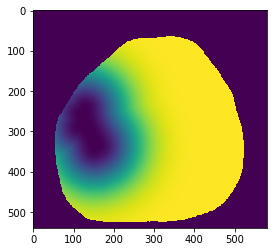

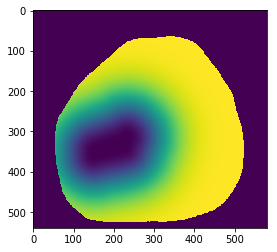

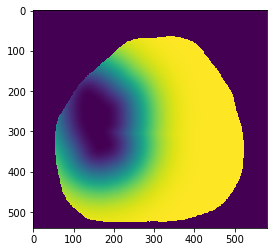

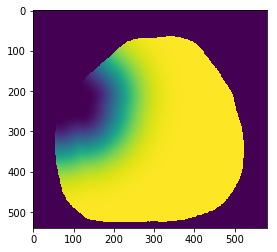

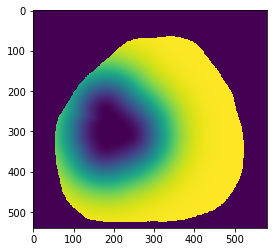

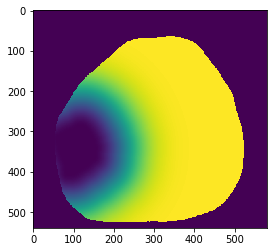

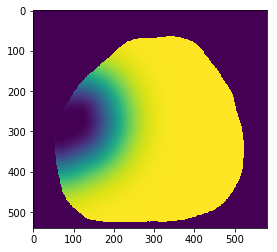

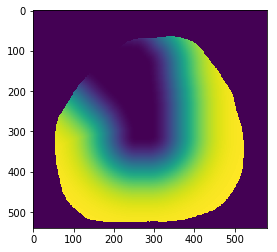

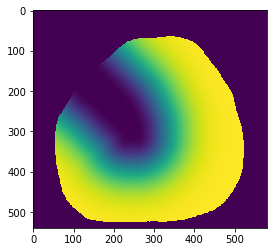

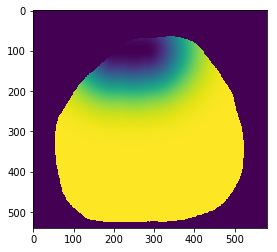

In [23]:
A = np.zeros(valid_mask.shape, dtype=np.float32)
for dist in region_mats[1]:
        A[valid_mask] = dist
        #plt.imshow(1 /(1 + np.exp(-1*.01 * A)))
        plt.imshow(A)
        plt.show()

In [24]:
region_metadata = LsNMF.RegionMetadata(region_mats[0].shape[0],
                                       region_mats[0].shape[1:],
                                       device=device)

In [ ]:
region_metadata.set(torch.from_numpy(region_mats[0].astype(np.uint8)),
                    torch.from_numpy(region_mats[1]),
                    torch.from_numpy(region_mats[2].astype(np.int64)))

In [ ]:
torch.cuda.synchronize()
print('v SVD Initialization')
t0 = time.time()
region_videos = LsNMF.factor_region_videos(video_mats,
                                           region_mats[0],
                                           rank_range[1])
torch.cuda.synchronize()
print("\'-total : %f" % (time.time() - t0))

v SVD Initialization


In [ ]:
low_rank_video = LsNMF.LowRankVideo(
    (int(np.sum(valid_mask)),) + video_mats[1].shape, device=device
)

In [ ]:
low_rank_video.set(torch.from_numpy(video_mats[0].T),
                   torch.from_numpy(video_mats[1]))

In [ ]:
torch.cuda.synchronize()
print('v Rank Line Search')
t0 = time.time()
debug = LsNMF.rank_linesearch(low_rank_video,
                              region_metadata,
                              region_videos,
                              maxiter_rank=50,
                              maxiter_lambda=200,
                              maxiter_hals=15,
                              lambda_step=1.35,
                              lambda_init=1e-3,
                              loc_thresh=50,
                              r2_thresh=.98,
                              rank_range=rank_range,
                              verbose=[True, False, False],
                              sample_prop=(1,1))
torch.cuda.synchronize()
print("\'-total : %f" % (time.time() - t0))

In [ ]:
len(debug)

In [ ]:
region_ranks = [0]
region_idx = []
for rdx in torch.unique(debug.regions.data):
    region_ranks.append(torch.sum(rdx == debug.regions.data).item())
    region_idx.append(rdx.item())

In [ ]:
print((np.min(region_ranks),
       np.mean(region_ranks),
       np.max(region_ranks)))

In [ ]:
print((np.sum(np.array(region_ranks) == np.max(region_ranks)), len(region_metadata)))

In [ ]:
A = np.zeros(valid_mask.shape, dtype=np.float32)
for rdx, i in zip(region_idx, np.cumsum(region_ranks[:-1])):
    fig, axs = plt.subplots(1 + int(region_ranks[1+rdx] / 4), 4,
                            figsize=(16,(1 + int(region_ranks[1+rdx] / 4)) * 4))
    axs = axs.reshape((int(np.prod(axs.shape)),))
    A[valid_mask] = debug.distance.data[i].cpu()==0
    axs[0].imshow(A)
    axs[0].set_title("Region: {}".format(rdx+1))
    for j, ax in enumerate(axs[1:]):
        if i + j < len(debug) and debug.regions.data[i+j].item() == rdx:
            A[valid_mask] = debug.spatial.data[i+j].cpu()
            ax.set_title("Component {}".format(i+j))
        else:
            A[valid_mask] = 0
        ax.imshow(A)
        
    plt.show()

In [ ]:
torch.min(debug.lambdas.data)

In [ ]:
torch.max(debug.lambdas.data)

In [ ]:
plt.hist(np.log(debug.lambdas.data.cpu()), bins=torch.unique(debug.lambdas.data).shape[0])
plt.show()

In [ ]:
np.exp(-6)

In [ ]:
np.repeat(np.arange(len(region_ranks[1:])), region_ranks[1:])[
    np.argwhere((torch.min(debug.lambdas.data) == debug.lambdas.data).cpu()).flatten()
]

In [ ]:
torch.argmin(debug.lambdas.data)

In [ ]:
debug.lambdas.data

In [ ]:
torch.min(debug.lambdas.data) == debug.lambdas.data

In [ ]:
np.exp(np.linspace(-7,7)[1:] - np.linspace(-7,7)[:-1])

## rank_linesearch(...)

In [ ]:
region_lr_videos = region_videos
init_rank=rank_range[0]
maxiter_hals=30

In [ ]:
import demix

In [ ]:
max_ranks, curr_ranks, region_factors = [], [], []
for video in region_lr_videos:
    max_ranks.append(len(video))
    region_factors.append(
        demix.HalsSNMF(max_ranks[-1],
                      video.shape[:-1] + (max_ranks[-1],) + video.shape[-1:],
                device=device)
    )
    LsNMF.init_from_low_rank_video(video, region_factors[-1], init_rank, maxiter=maxiter_hals, verbose=True)

In [ ]:
nmf_factors = LsNMF.LocalizedNMF(np.sum(max_ranks),
                                 low_rank_video.shape[:-1] + (np.sum(max_ranks),) + low_rank_video.shape[-1:],
                                 device=device)

In [ ]:
nmf_factors.set_from_regions(region_factors, region_metadata)

### lambda_linesearch(...)

In [ ]:
video = low_rank_video
localized_factorization = debug#nmf_factors
lambda_init = 1
lambda_step = 1.5
loc_thresh=20

In [ ]:
_ = localized_factorization.lambdas.data.fill_(lambda_init)

In [ ]:
_ = torch.mul(localized_factorization.distance.data,
              .5 * localized_factorization.lambdas.data[...,None],
              out=localized_factorization.distance.scratch)

In [ ]:
LsNMF.hals(video, localized_factorization, maxiter=maxiter_hals, verbose=True)

In [ ]:
debug.intermediate.data.stride()

In [ ]:
tmp = torch.matmul(video.temporal.data, debug.temporal.data.t())

In [ ]:
tmp.shape

In [ ]:
tmp.stride()

In [ ]:
tmp.set_(source=tmp.storage(),
         storage_offset=tmp.storage_offset(),
         size=(941,81),
         stride=tmp.stride())

In [ ]:
tmp.shape

In [ ]:
tmp.stride()

In [ ]:
_ = torch.matmul(video.temporal.data, debug.temporal.data.t(), out=tmp)

In [ ]:
tmp.shape

In [ ]:
tmp.stride()

In [ ]:
_ = torch.index_select(region_metadata.support.data.to(torch.float32),
                       0,
                       localized_factorization.regions.data,
                       out=localized_factorization.distance.scratch)

In [ ]:
_ = torch.mul(localized_factorization.spatial.data,
              localized_factorization.distance.scratch,
              out=localized_factorization.spatial.scratch)

In [ ]:
_ = torch.div(torch.norm(localized_factorization.spatial.data, p=2, dim=-1),
              torch.norm(localized_factorization.spatial.scratch, p=2, dim=-1),
              out=localized_factorization.scale.data)

In [ ]:
print(localized_factorization.scale.data)

In [ ]:
_ = localized_factorization.scale.data.gt_(np.sqrt(100 / loc_thresh))

In [ ]:
torch.sum(localized_factorization.scale.data)

In [ ]:
_ = torch.mul(localized_factorization.scale.data,
              lambda_step - 1,
              out=localized_factorization.scale.data)

In [ ]:
_ = torch.add(localized_factorization.scale.data,
              1.0,
              out=localized_factorization.scale.data)

In [ ]:
_ = torch.mul(localized_factorization.scale.data,
              localized_factorization.lambdas.data,
              out=localized_factorization.lambdas.data)

In [ ]:
print(localized_factorization.lambdas.data)

## rank_linesearch(...)

In [ ]:
refit_flags = [False] * len(region_metadata)
curr_ranks = [2] * len(region_metadata)

In [ ]:
for rdx, (rank, max_rank) in enumerate(zip(curr_ranks, max_ranks)):
    if rank < max_rank:
        refit_flags[rdx] = LsNMF.evaluate_fit_to_region(low_rank_video,
                                                        nmf_factors,
                                                        region_metadata.support.data[rdx])